# Further Data Analysis

We're going to conduct a bit more Data Analysis and in this process also conduct a simple mean imputation as a baseline model for our data.

First of all we import our data.

In [23]:
library(lubridate)
library(dlookr)
library(dplyr)
library(mice)
library(VIM)
library(Amelia)
library(Zelig)
library(outliers)
library(EnvStats)


Attaching package: 'EnvStats'


The following object is masked from 'package:Zelig':

    predict


The following objects are masked from 'package:dlookr':

    kurtosis, skewness


The following objects are masked from 'package:stats':

    predict, predict.lm


The following object is masked from 'package:base':

    print.default




In [2]:
temp2 <- tempfile()
start <- proc.time()
download.file("https://github.com/Galeforse/DST-Assessment-02/raw/main/Data/1_percent_data.csv.gz",temp2)
data <- (read.csv(gzfile(temp2)))
print("Data imported in:")
print(seconds_to_period((proc.time()-start)[3]))

[1] "Data imported in:"
[1] "3.95S"


In [3]:
temp2 <- tempfile()
start <- proc.time()
download.file("https://github.com/Galeforse/DST-Assessment-02/raw/main/Data/1_percent_data_head.csv.gz",temp2)
datah <- (read.csv(gzfile(temp2)))
print("Data imported in:")
print(seconds_to_period((proc.time()-start)[3]))

[1] "Data imported in:"
[1] "2.01S"


In [4]:
head(data)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,http,0.03,481,8133,RSTO,0,ShADadfR,8,813,9,8505
2,1331923392,192.168.202.110,11574,192.168.23.253,1724,tcp,,NA,NA,NA,REJ,0,Sr,1,48,1,40
3,1331905217,192.168.202.83,41267,192.168.206.44,8010,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40
4,1331994375,192.168.202.83,58519,192.168.206.44,5214,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40
5,1331999507,192.168.202.140,25774,192.168.23.252,1625,tcp,,NA,NA,NA,S0,0,S,1,48,0,0
6,1331935766,192.168.202.83,60760,192.168.206.44,1580,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40


In [5]:
mtab0=data.frame(
    missingduration=is.na(data[,"duration"]),
    proto=data[,"proto"])
mtab=table(mtab0)
(apply(mtab,2,function(x)x/sum(x)))

,icmp,tcp,udp
FALSE,0.8683921,0.1649403,0.3135747
TRUE,0.1316079,0.8350597,0.6864253


In [6]:
mtab0=data.frame(
    missingduration=is.na(datah[,"duration"]),
    proto=datah[,"proto"])
mtab=table(mtab0)
(apply(mtab,2,function(x)x/sum(x)))

,icmp,tcp,udp
FALSE,0.2989691,0.6409311,0.2180095
TRUE,0.7010309,0.3590689,0.7819905


The above code is taken from the workshop on missing data and is used to see the randomness of the missing `duration` (which will therefore also apply to `orig_bytes` and `resp_bytes`). It seems that the data is not missing completely at random as there seems to be trends between what protocol corresponds to missing data. However it is interesting to note that oddly enough, for the two datasets we're looking at, the `tcp` and `icmp` protocol seem to flip in trend between the two, which suggests this trend may not be prevalent throughout the whole data set, but it could also be bias from our sample.

(As an extra note in the workshop the above command was used on the complete dataset and showed a trend similar to the random sample `data` set so it seems that most of the data would follow this trend and our "head" data is skewed in that regard.)

Now, we're going to have a look for some outliers.

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"98 y values <= 0 omitted from logarithmic plot"


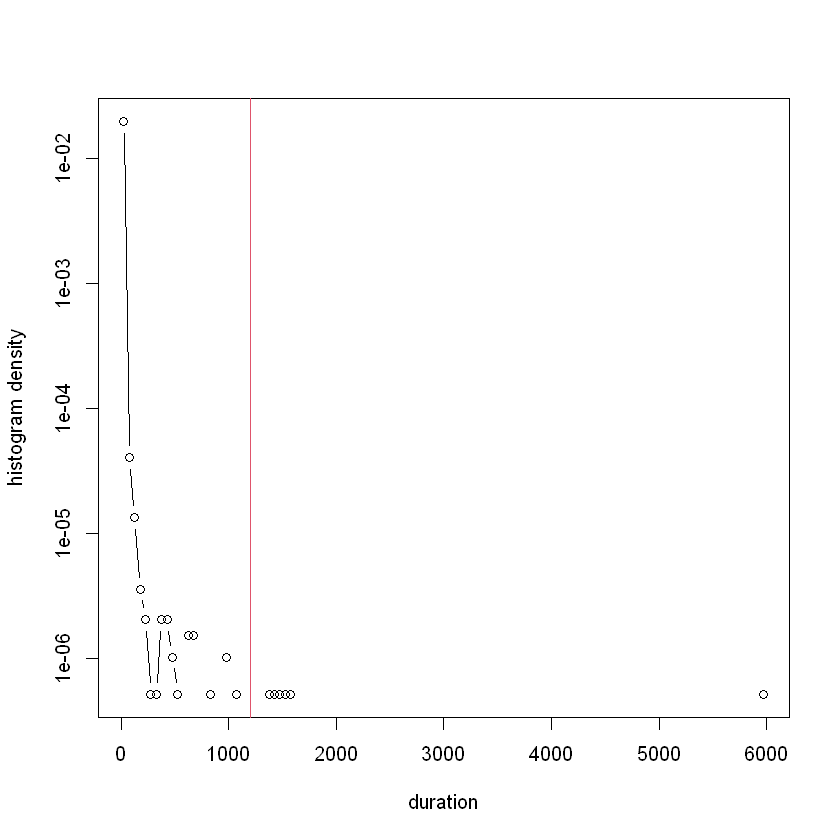

In [7]:
nbreaks=101 
thist=hist(data[,"duration"],breaks=nbreaks,plot=FALSE)

plot(thist$mids,thist$density,log="y",type="b",
     xlab="duration",ylab="histogram density")
threshold=1200 
abline(v=threshold,col=2) 

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"44 y values <= 0 omitted from logarithmic plot"


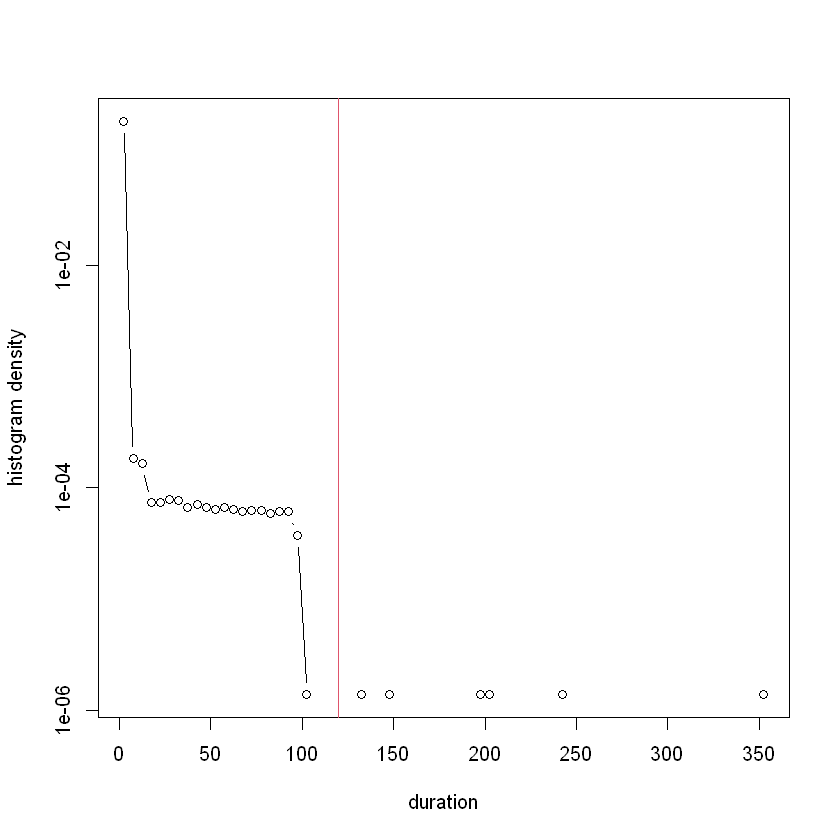

In [8]:
nbreaks=101 
thist=hist(datah[,"duration"],breaks=nbreaks,plot=FALSE)

plot(thist$mids,thist$density,log="y",type="b",
     xlab="duration",ylab="histogram density")
threshold=120
abline(v=threshold,col=2) 

We see that the outliers in the "head" data are considerably more spaced out than in the randomly sampled but there seems to a similar amount in each dataset. The most noteable thing we can see in these graphs is that the duration variable in the sampled data is considerable less than in the randomly sampled, possibly showing a time bias on the data (i.e. the head data is early on in the data and might not reflect the general distribution of the data).

We can verify whether each point is an outlier with different statistical tests. We first want use Grubbs test but this relys on our data being approximately normally distributed. But our data contains missing values so we use mean imputation to impute some data. 

We will also drop the service column due to the reasons previously stated.

In [9]:
data1 <- subset(data, select = -c(service))
datah1 <- subset(datah, select = -c(service))

We are also going to add a `logduration` column as for some methods the `duration` variable ends up being regressed wrongly resulting in a negative value which we do not want to see!

In [10]:
data1[,"logduration"]=log(data1[,"duration"])
datah1[,"logduration"]=log(datah1[,"duration"])

In [11]:
conn_mean<-data1
conn_mean[is.na(conn_mean[,"duration"]),
              "duration"]=
    mean(na.omit(conn_mean[,"duration"]))
conn_mean[is.na(conn_mean[,"orig_bytes"]),
              "orig_bytes"]=
    mean(na.omit(conn_mean[,"orig_bytes"]))
conn_mean[is.na(conn_mean[,"resp_bytes"]),
              "resp_bytes"]=
    mean(na.omit(conn_mean[,"resp_bytes"]))
conn_mean[is.na(conn_mean[,"logduration"]),
              "logduration"]=
    mean(na.omit(conn_mean[,"logduration"]))
head(conn_mean)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,logduration
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,0.030000,481.0,8133.0000,RSTO,0,ShADadfR,8,813,9,8505,-3.506558
2,1331923392,192.168.202.110,11574,192.168.23.253,1724,tcp,1.474315,518931.4,666.5486,REJ,0,Sr,1,48,1,40,-3.160371
3,1331905217,192.168.202.83,41267,192.168.206.44,8010,tcp,1.474315,518931.4,666.5486,REJ,0,Sr,1,60,1,40,-3.160371
4,1331994375,192.168.202.83,58519,192.168.206.44,5214,tcp,1.474315,518931.4,666.5486,REJ,0,Sr,1,60,1,40,-3.160371
5,1331999507,192.168.202.140,25774,192.168.23.252,1625,tcp,1.474315,518931.4,666.5486,S0,0,S,1,48,0,0,-3.160371
6,1331935766,192.168.202.83,60760,192.168.206.44,1580,tcp,1.474315,518931.4,666.5486,REJ,0,Sr,1,60,1,40,-3.160371


In [12]:
conn_meanh<-datah1
conn_meanh[is.na(conn_meanh[,"duration"]),
              "duration"]=
    mean(na.omit(conn_meanh[,"duration"]))
conn_meanh[is.na(conn_meanh[,"orig_bytes"]),
              "orig_bytes"]=
    mean(na.omit(conn_meanh[,"orig_bytes"]))
conn_meanh[is.na(conn_meanh[,"resp_bytes"]),
              "resp_bytes"]=
    mean(na.omit(conn_meanh[,"resp_bytes"]))
conn_meanh[is.na(conn_meanh[,"logduration"]),
              "logduration"]=
    mean(na.omit(conn_meanh[,"logduration"]))
head(conn_meanh)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,logduration
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,1331901000,192.168.202.79,50463,192.168.229.251,80,tcp,0.3745079,50.35395,21.58427,SH,0,Fa,1,52,1,52,-3.664367
2,1331901000,192.168.202.79,46117,192.168.229.254,443,tcp,0.3745079,50.35395,21.58427,SF,0,dDafFr,3,382,9,994,-3.664367
3,1331901000,192.168.202.79,50465,192.168.229.251,80,tcp,0.0100000,166.00000,214.00000,SF,0,ShADfFa,4,382,3,382,-4.605170
4,1331901000,192.168.202.79,50467,192.168.229.251,80,tcp,0.0100000,166.00000,214.00000,SF,0,ShADfFa,4,382,3,382,-4.605170
5,1331901000,192.168.202.79,46119,192.168.229.254,443,tcp,0.0200000,544.00000,1060.00000,SF,0,ShADadfFr,8,968,13,1744,-3.912023
6,1331901000,192.168.202.79,46121,192.168.229.254,443,tcp,0.0100000,544.00000,1060.00000,SF,0,ShADadfFr,8,968,13,1744,-4.605170


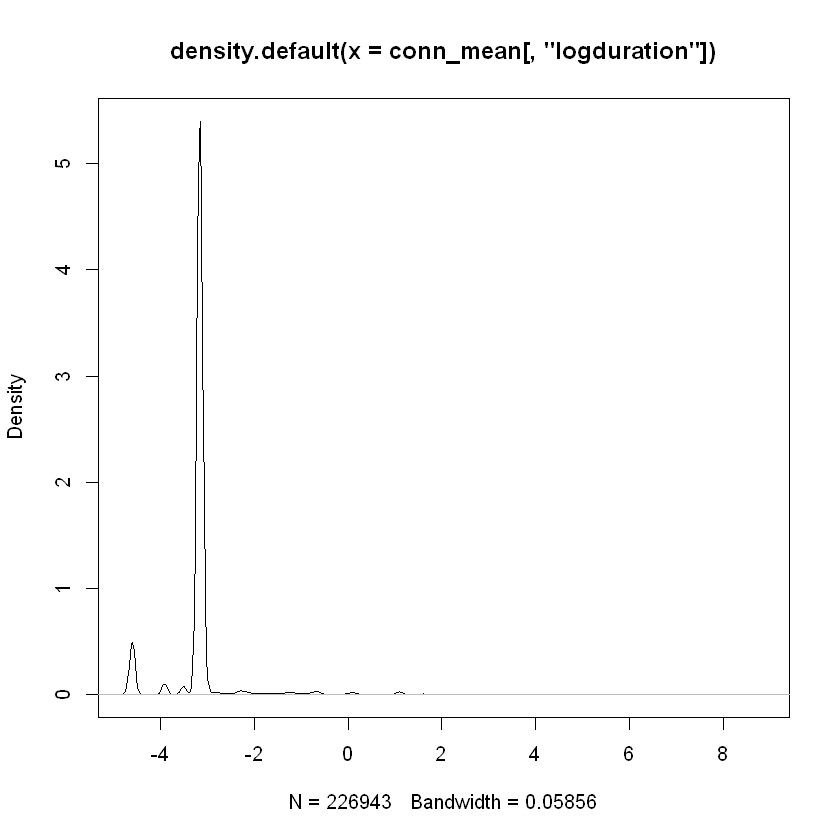

In [15]:
plot(density(conn_mean[,"logduration"]))

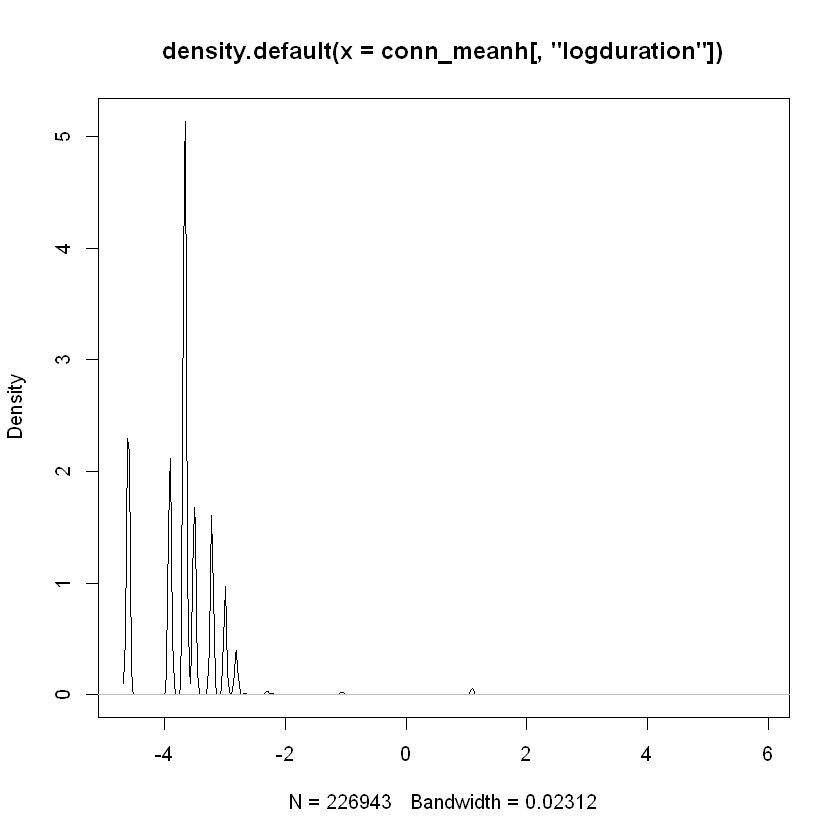

In [18]:
plot(density(conn_meanh[,"logduration"]))

Taking a step back we're going to test for outliers as we did above but this time using the Grubbs test.

In [21]:
test <- grubbs.test(data[,"duration"])
test


	Grubbs test for one outlier

data:  data[, "duration"]
G = 157.45858, U = 0.36486, p-value < 2.2e-16
alternative hypothesis: highest value 5993.18 is an outlier


In [22]:
test <- grubbs.test(datah[,"duration"])
test


	Grubbs test for one outlier

data:  datah[, "duration"]
G = 75.09267, U = 0.96106, p-value < 2.2e-16
alternative hypothesis: highest value 351.96 is an outlier


This confirms what we saw visually in the histogram above.

Grubbs test can only test the highest or lowest value so we can use Rosner's test since it is designed to detect several outliers at once and it is designed to avoid the problem of 'masking', which is where  an outlier that is close in value to another outlier can go undetected. Be warned that this generates a very long string of calculations that fill the screen several times over, and even then what we gather from this is test is not that useful so we will continue on.

In [27]:
test <- rosnerTest(data[,"duration"], k = 5)
test

Warning message in rosnerTest(data[, "duration"], k = 5):
"187905 observations with NA/NaN/Inf in 'x' removed."


$distribution
[1] "Normal"

$statistic
      R.1       R.2       R.3       R.4       R.5 
157.45858  68.30291  70.85079  72.32054  75.20810 

$sample.size
[1] 39038

$parameters
k 
5 

$alpha
[1] 0.05

$crit.value
lambda.1 lambda.2 lambda.3 lambda.4 lambda.5 
4.842013 4.842008 4.842003 4.841998 4.841993 

$n.outliers
[1] 5

$alternative
[1] "Up to 5 observations are not\n                                 from the same Distribution."

$method
[1] "Rosner's Test for Outliers"

$data
    [1]    0.030000    0.010000    0.010000    0.010000    0.200000    0.060000
    [7]    0.110000    1.130000    0.270000    0.010000    0.040000    0.110000
   [13]    0.010000    0.030000    0.110000    0.420000    0.020000    0.010000
   [19]    0.250000    0.350000    0.020000    0.010000    0.010000    0.270000
   [25]    0.040000    0.010000    0.010000    2.950000    0.030000    0.030000
   [31]    0.030000    0.030000    0.030000    0.550000    0.010000    0.010000
   [37]    0.260000    0.020000    

The most important part here is the mean imputation, which we will use as our baseline model for predicting missing data. Above we have tried it on our sampled datasets, however we deliberated on how best to check the accuracy of our model, and in doing so decided it would be best to create some new data from non-missing values in the data set, and artificially add missing data in the same row for `duration`, `orig_bytes` and `resp_bytes`. 

We also added some data for `service` but as we are not interested in it and drop it in most cases the distribution of this didn't matter too much. The main issue that could arise here is how the data is missing in the original data. What we will test here is how good our model is at predicting based off of other non-missing values in the data. This is not an ideal solution but we struggled to come up with a method of comparing models that worked for each and every implementation that we conducted.

In the missForest implementation we make a few comparisons using the r-squared value, but as a general comparison we wanted to compare the values in each imputed dataset with the complete data (hence why we artificially added NA) to see how accurate the predictions were.

Below I will just mean impute on this data.

In [28]:
temp2 <- tempfile()
start <- proc.time()
download.file("https://github.com/Galeforse/DST-Assessment-02/raw/main/Data/test_missing.csv.gz",temp2)
data3 <- (read.csv(gzfile(temp2)))
print("Data imported in:")
print(seconds_to_period((proc.time()-start)[3]))

[1] "Data imported in:"
[1] "2.02999999999975S"


In [30]:
data3[,"logduration"]=log(data3[,"duration"])

In [31]:
conn_meanh<-data3
conn_meanh[is.na(conn_meanh[,"duration"]),
              "duration"]=
    mean(na.omit(conn_meanh[,"duration"]))
conn_meanh[is.na(conn_meanh[,"orig_bytes"]),
              "orig_bytes"]=
    mean(na.omit(conn_meanh[,"orig_bytes"]))
conn_meanh[is.na(conn_meanh[,"resp_bytes"]),
              "resp_bytes"]=
    mean(na.omit(conn_meanh[,"resp_bytes"]))
conn_meanh[is.na(conn_meanh[,"logduration"]),
              "logduration"]=
    mean(na.omit(conn_meanh[,"logduration"]))
head(conn_meanh)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,logduration
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,1331902224,192.168.202.79,45300,192.168.229.153,5357,tcp,http,0.010000,173.000,513.00,SF,0,ShADfFa,4,389,3,677,-4.605170
2,1331909172,192.168.202.110,44457,192.168.22.253,80,tcp,http,0.010000,434.000,465.00,RSTO,0,ShADadfR,5,702,4,681,-4.605170
3,1331915516,192.168.202.102,4261,192.168.28.202,80,tcp,http,0.030000,478.000,8133.00,RSTO,0,ShADadfR,8,810,9,8505,-3.506558
4,1331915509,192.168.202.118,35260,192.168.26.152,80,tcp,http,2.802912,1443.371,88039.37,SF,0,ShADdFaf,7,607,5,1903,-2.387707
5,1331915606,192.168.202.102,4910,192.168.23.202,80,tcp,http,2.802912,1443.371,88039.37,RSTO,0,ShADadRf,7,778,7,5674,-2.387707
6,1331915944,192.168.202.102,1617,192.168.23.202,80,tcp,http,0.030000,496.000,8133.00,RSTO,0,ShADadfR,8,828,9,8505,-3.506558


In [32]:
library(crunch)
write.csv.gz(conn_meanh,"G:\\Users\\Gabriel\\Documents\\Education\\UoB\\GitHubDesktop\\DST-Assessment-02\\Data\\Mean_impute_fill.csv.gz",row.names=FALSE)


Attaching package: 'crunch'


The following objects are masked from 'package:dplyr':

    combine, filter, id


The following object is masked from 'package:mice':

    filter


The following objects are masked from 'package:stats':

    filter, rstandard, setNames


The following object is masked from 'package:graphics':

    title


The following object is masked from 'package:utils':

    write.csv


The following object is masked from 'package:base':

    table


